# Ajuste de la curva de luz del telescopio OGLE
En este notebook se ajusta la curva de luz del telescopio OGLE. Se ha escogido el evento  OGLE-2023-BLG-0011 [https://ogle.astrouw.edu.pl/ogle4/ews/2023/blg-0011.html](https://ogle.astrouw.edu.pl/ogle4/ews/2023/blg-0011.html).

## 1. Definimos el modelo de la curva de luz: 
El modelo de intensidad a medida que sucede el evento vendrá dado por:
$$I(t)=I_0-2.5\log_{10}(\mu(t)),$$
donde $\mu(t)$ es el aumento de la lente: $$\mu(t)=\frac{y(t)^2+2}{y(t)\sqrt{y(t)^2+4}}$$
$y(t)$ define la trayectoria de la fuente como sigue:
$y(t)=\sqrt{y_0^2+\frac{(t-t_0)^2}{t_E^2}},$

La función I(t) se guarda en la función `model_I`. Las funciones `plot` y `plotraw` sirven para graficar el ajuste. Creamos una clase **fuente_puntual** para guardar estas funciones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


class fuente_puntual(object):

    def __init__(self, fichero):
        self.dat = np.loadtxt(fichero)
        self.dic = {'t':self.dat[:,0], 'I':self.dat[:,1], 'Ierr':self.dat[:,2],'t0':2450000}
    
    #implementamos función modelo
    def model_I(self,t,I0,y0,t0,tE):
        y=np.sqrt(y0**2+((t-t0)/tE)**2)
        res=I0-2.5*np.log10((y**2+2)/(y*(np.sqrt(y**2+4))))
        return res
    
    def plot(self,params):
        plt.rcParams['figure.figsize'] = (7.0,5.0)
        plt.xlabel('HJD - '+str(self.dic['t0']), fontsize=14)
        plt.ylabel('Magnitud I', fontsize=14)
        plt.gca().invert_yaxis()
        paramnames=['I0', 'y0', 't0', 'tE']
        param_labels=[r'$I_0$',r'$y0$', r'$t_{0}$', r'$t_E$']
        tgrid=np.linspace(self.dic['t'].min(), self.dic['t'].max(), 1000)
        plt.errorbar(self.dic['t'],self.dic['I'], yerr=self.dic['Ierr'], fmt='.')
        plt.plot(tgrid, self.model_I(tgrid, **params),label='modelo', zorder=2)
        plt.legend()
        
    def plotraw(self):
        plt.rcParams['figure.figsize'] = (7.0,5.0)
        plt.errorbar(self.dic['t'],self.dic['I'], yerr=self.dic['Ierr'], fmt='.')
        plt.xlabel('HJD - '+str(self.dic['t0']), fontsize=14)
        plt.ylabel('Magnitud I', fontsize=14)
        plt.gca().invert_yaxis()


### Graficamos los datos sin ajustar

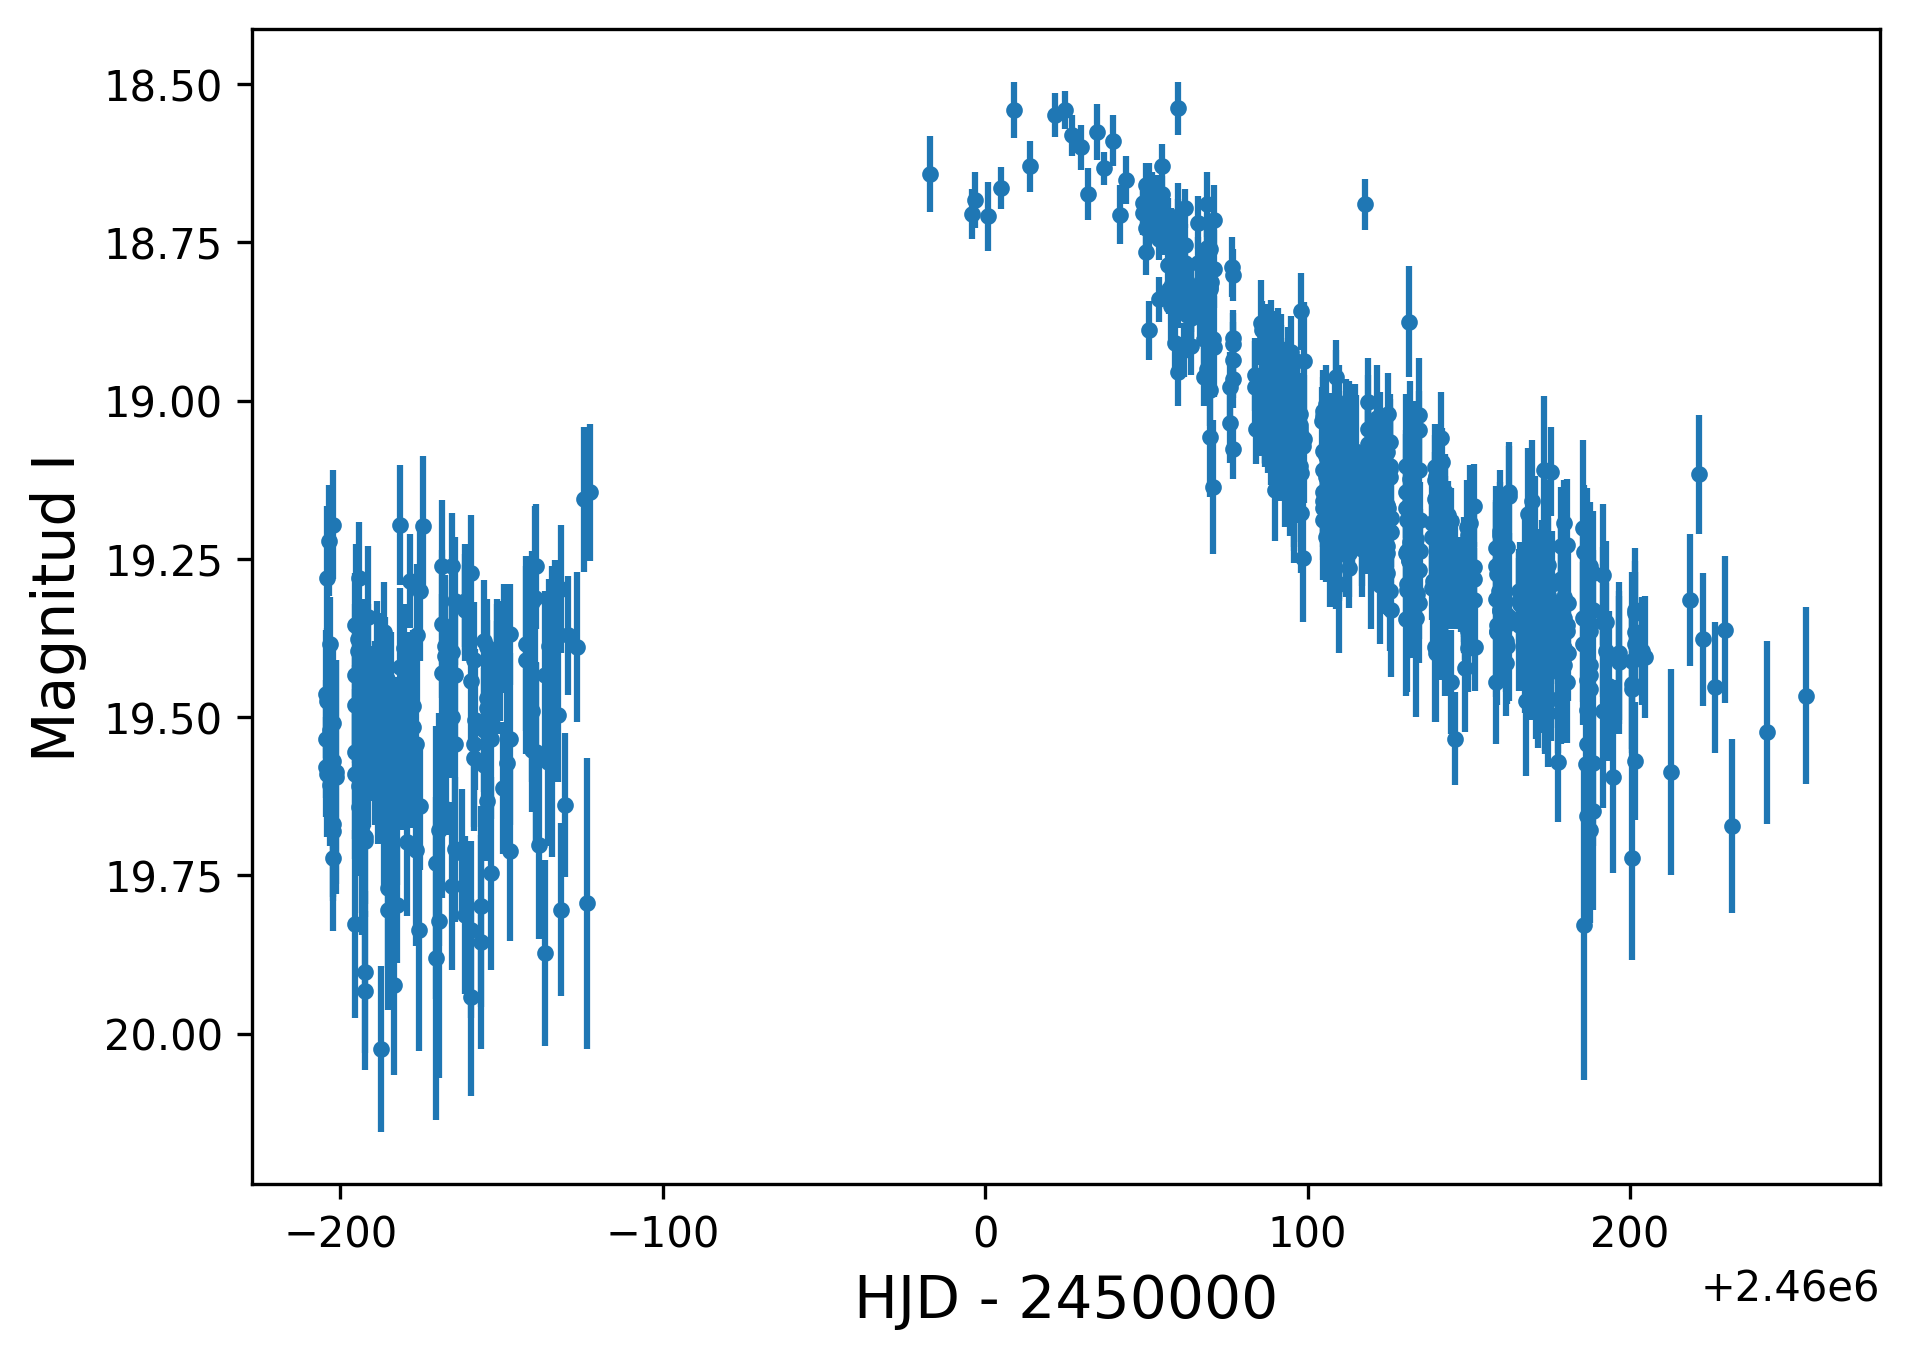

In [2]:
fuente = fuente_puntual('phot2023.dat')
fuente.plotraw()

## 2. Elegimos parámetros iniciales haciendo ajuste "a mano":
Después de probar se han elejido los siguiente parámetros iniciales:
$$\{I_0=19.7, y_0=0.4, t_0=10030, t_E=130\}$$

Text(0.5, 1.0, 'AJUSTE A MANO')

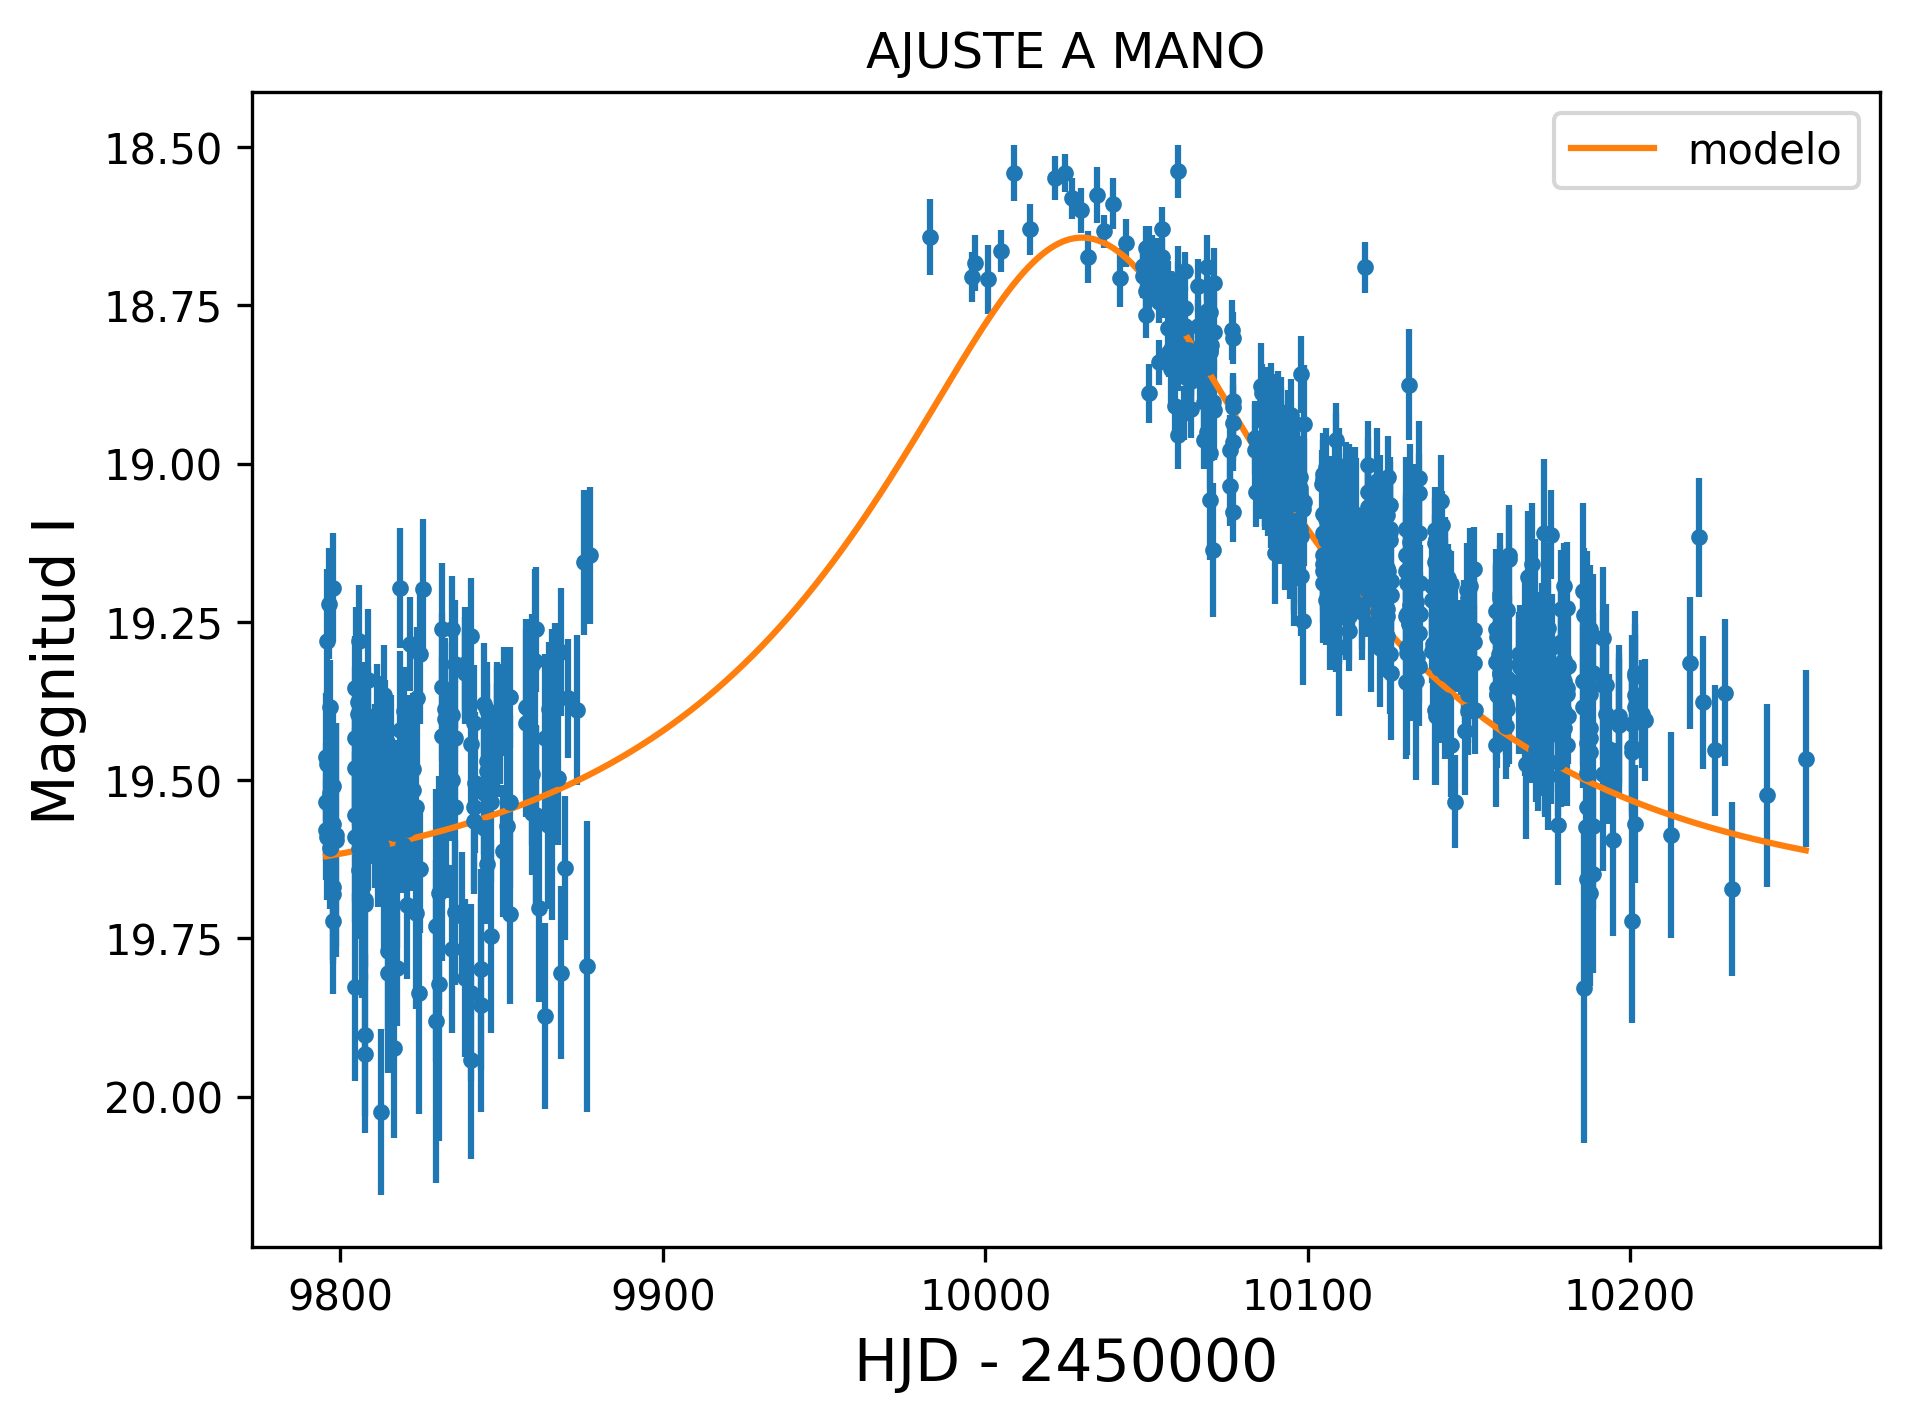

In [3]:
fuente.dic['t'] -= fuente.dic['t0']
params={'I0':19.70, 'y0':0.40, 't0':10030, 'tE':130} #haciendo prueba y error llegamos a esto
fuente.plot(params)
plt.title('AJUSTE A MANO')

## 3. Hacemos el ajuste real
Se usa un algoritmo de minimización de la librería `lmfit`. Definimos la función a minimizar como sigue:

$$\chi^2(I_0,t_0,t_E,y_0)=\sum_{i=0}^{N}\frac{(I(t_i)-I_i)^2}{\varepsilon_i^2}$$
Esta función se guarda en la función `coste`.

In [4]:
#EMPEZAMOS AJUSTANDO MEJOR EL MODELO PARA ELLO USAMOS LMFIT
import lmfit

#valores iniciales para el parametro (elegimos los hecho a mano).
p=lmfit.Parameters()
p.add_many(('t0',10030,True,9900,10200), ('tE',130,True,1.,250),
           ('y0',0.40,True,0.01,1.0),('I0',19.70,True,19,21))
shape=np.array(np.shape(fuente.dat))
i=i=np.linspace(0,shape[0]-1,shape[0],dtype='int')
def coste(p):
    paramsnew={'I0':p['I0'], 'y0':p['y0'], 't0':p['t0'], 'tE':p['tE']}
    res=np.ndarray(shape[0])
    for i in range(shape[0]):
        res[i]=((fuente.model_I(fuente.dic['t'][i],**paramsnew)-
                 fuente.dic['I'][i])/(fuente.dic['Ierr'][i]))
    return res




name,value,standard error,relative error,initial value,min,max,vary
t0,10020.7418,1.98501069,(0.02%),10030,9900.00000,10200.0000,True
tE,146.302777,9.26203067,(6.33%),130,1.00000000,250.000000,True
y0,0.42248639,0.01400221,(3.31%),0.4,0.01000000,1.00000000,True
I0,19.6215369,0.02821205,(0.14%),19.7,19.0000000,21.0000000,True


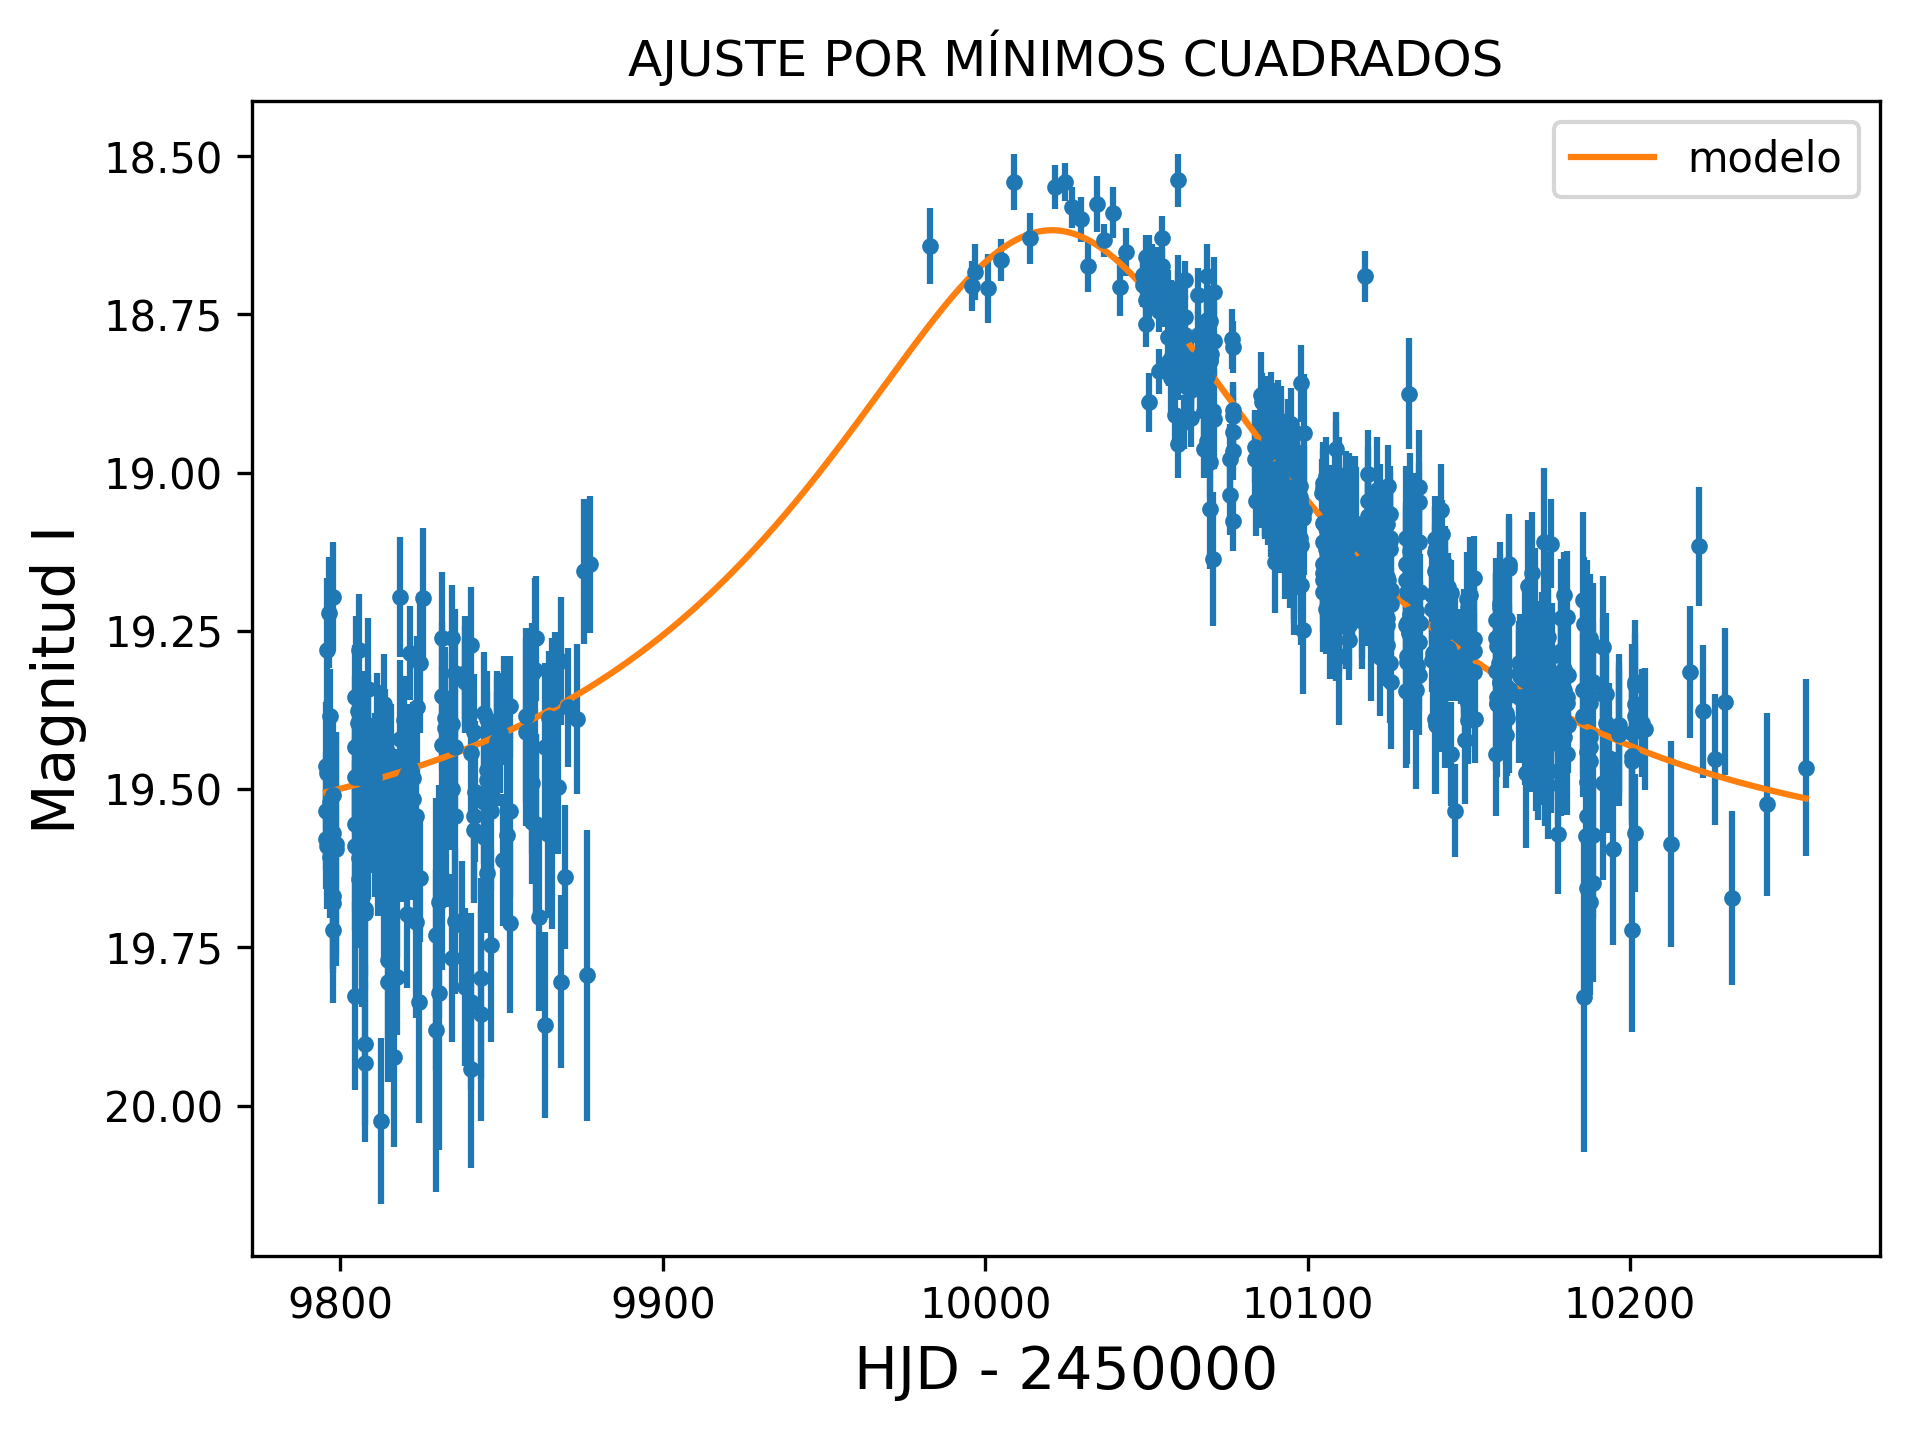

In [5]:
mi2=lmfit.minimize(coste,p,method='leastsq')
plq=mi2.params
paramslq={'I0':plq['I0'], 'y0':plq['y0'], 
          't0':plq['t0'], 'tE':plq['tE']}
plt.title('AJUSTE POR MÍNIMOS CUADRADOS')
fuente.plot(paramslq)
mi2.params